In [1]:
import numpy as np
np.random.seed(0)
import mltools as ml
reload(ml)
reload(ml.base)
import matplotlib.pyplot as plt   # use matplotlib for plotting with inline plots
%matplotlib inline

## P1: Linear Regression
First, we'll load the data, and split it into training and evaluation blocks:

In [2]:
curve = np.genfromtxt("data/curve80.txt",delimiter=None)
print curve.shape
X = curve[:,0]         # extract features
X = X[:,np.newaxis]    # force X to be shape (M,1)     
Y = curve[:,1]         # extract target values
print X.shape, Y.shape # check shapes
Xt,Xe,Yt,Ye = ml.splitData(X,Y,0.75)

(80, 2)
(80, 1) (80,)


Now, let's train a simple linear regression model on the training data, and plot the training data, evaluation data, and our linear fit:

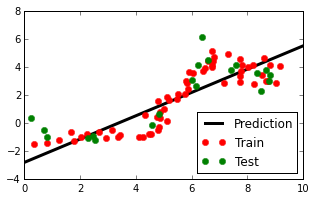

In [3]:
import mltools.linear
reload(ml.linear)

lr = ml.linear.linearRegress(Xt,Yt, reg=0)  # init and train the model
# to plot the prediction, we'll evaluate our model at a dense set of locations:
xs = np.linspace(0,10,200)
xs = xs[:,np.newaxis]
ys = lr.predict(xs)

plt.rcParams['figure.figsize'] = (5.0, 3.0)
lines = plt.plot(xs,ys,'k-',Xt,Yt,'r.',Xe,Ye,'g.', linewidth=3,markersize=12)  
plt.legend(['Prediction','Train','Test'],loc='lower right');

In [4]:
print "MSE (Train) = ", lr.mse(Xt,Yt)
print "MSE (Test)  = ", lr.mse(Xe,Ye)

MSE (Train) =  1.12771195561
MSE (Test)  =  2.24234920301


### Polynomial features
As mentioned in the homework, you can create additional features manually, e.g.,

In [5]:
Xt2 = np.zeros((Xt.shape[0],2))
print Xt2.shape
print Xt.shape
Xt2[:,0] = Xt[:,0]
Xt2[:,1] = Xt[:,0]**2
print Xt2[0:6,:]   # look at a few data points to check:

(60, 2)
(60, 1)
[[  3.4447005   11.86596153]
 [  4.7580645   22.63917779]
 [  6.4170507   41.17853969]
 [  5.7949309   33.58122414]
 [  7.7304147   59.75931143]
 [  7.8225806   61.19276724]]


or, you can create them using the provided "fpoly" function:

In [6]:
import mltools.transforms as xform
Xt2 = xform.fpoly(Xt,2, bias=False)
print Xt2[0:6,:]   # look at the same data points -- same values

[[  3.4447005   11.86596153]
 [  4.7580645   22.63917779]
 [  6.4170507   41.17853969]
 [  5.7949309   33.58122414]
 [  7.7304147   59.75931143]
 [  7.8225806   61.19276724]]


Now, let's try fitting a linear regression model using different numbers of polynomial features of x:

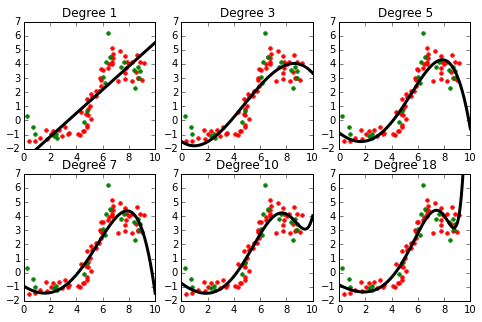

In [10]:
degrees = np.array(range(0,19))
learners = [ [] ]*19
errT = np.zeros((19,))
errV = np.zeros((19,))

plt.rcParams['figure.figsize'] = (8.0, 5.0)
fig,ax = plt.subplots(2,3)
axFlat = [a for row in ax for a in row]  # 2x3 subplots as simple list
i=0

for d in degrees:
    XtP = xform.fpoly(Xt, d, bias=False)  # generate polynomial features up to degree d
    XtP,params = xform.rescale(XtP)          # normalize scale & save transform parameters
    Phi = lambda X: xform.rescale(xform.fpoly(X,d,bias=False),params)[0]  # and define feature transform f'n
    learners[d] = ml.linear.linearRegress( Phi(Xt), Yt , reg=1e-3)
    if d in [1,3,5,7,10,18]:
        axFlat[i].plot(Xt,Yt,'r.',Xe,Ye,'g.',markersize=8)
        axFlat[i].set_title("Degree {}".format(d))
        axisSize = axFlat[i].axis()
        axFlat[i].plot(xs,learners[d].predict(Phi(xs)),'k-',linewidth=3)
        axFlat[i].axis(axisSize)   # restore original Y-range
        i += 1
        
    errT[d] = learners[d].mse(Phi(Xt),Yt)
    errV[d] = learners[d].mse(Phi(Xe),Ye)

Finally, let's plot the training and test error as a function of the polyomial degree we used:

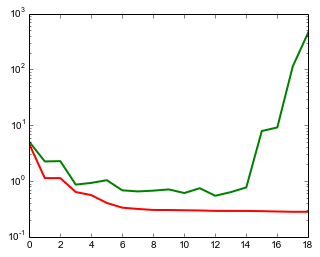

In [8]:
plt.rcParams['figure.figsize'] = (5.0, 4.0)

plt.semilogy(degrees,errT,'r-',degrees,errV,'g-',linewidth=2);

From this particular plot, it looks like degree 12 is the lowest validation error, and hence the model to pick (based on this information), although probably one could argue for anything between about 6 and 14.

## P2: Cross-validation
Cross validation is another method of model complexity assessment.  We use it only to determine the correct setting of complexity parameters ("hyperparameters"), such as how many and which features to use, or parameters like "k" in KNN, for which training error alone provides little information.  In particular, cross validation will not produce a model -- only a setting of the parameter values that cross-validation thinks will lead to a model with low test error.

We imagine that we do not have our "test" data $X_E, Y_E$, that we used for assessment in the previous problem, and will try to assess the quality of fit of our polynomial regressions using only the "training" data $X_T, Y_T$.  To this end, we split (again) the data multiple times, one for eack of the $K$ partitions (nFolds in the code), and repeat our entire training and evaluation procedure on each split:

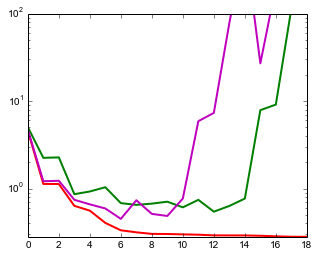

In [9]:
nFolds = 5
errX = np.zeros((19,5))

# Run over all degrees, and each fold for each degree
for d in degrees:
    for iFold in range(nFolds):
        # Extract the ith cross-validation fold (training/validation split)
        [Xti,Xvi,Yti,Yvi] = ml.crossValidate(Xt,Yt,nFolds,iFold)
        
        # Build the feature transform on these training data
        XtiP = xform.fpoly(Xti, d, bias=False) 
        XtiP,params = xform.rescale(XtiP)
        Phi = lambda X: xform.rescale(xform.fpoly(X,d,bias=False),params)[0]
        
        # Create and train the model, and save the error for this degree & split:
        lr = ml.linear.linearRegress( Phi(Xti),Yti )
        errX[d,iFold] = lr.mse( Phi(Xvi),Yvi )

# Now, to estimate the test performance of each degree, take the average error across the folds:
errX = np.mean(errX, axis=1)


plt.rcParams['figure.figsize'] = (5.0, 4.0)

plt.semilogy(degrees,errT,'r-',    # training error   (from P1)
             degrees,errV,'g-',    # validation error (from P1)
             degrees,errX,'m-',    # cross-validation estimate of validation error 
             linewidth=2);

plt.axis([0,18,0,1e2]);

The resulting plot shows a pretty similar characterization of performance as a function of degree to the validation data used in the previous problem (which, remember, we didn't access in this problem).  A noticable difference is that moderate to high degrees begin to degrade the performance (and begin overfitting) earlier than in the previous problem -- mainly, this is due to the 20% decrease in training data within our cross-validation process, which causes slighly lower degrees to begin overfitting.

(If you like, you can plot a learning curve to see how performance is changing for these degrees as a function of the number of training data.)

This illustrates how cross-validation can be used for model selection, as a pretty good surrogate for having additional validation / test data.

## P3: Kaggle
Here is an illustration of how to load & predict data for our Kaggle competition.

In [10]:
Xt = np.genfromtxt("../../kaggle/kaggle.X1.train.txt",delimiter=',')
Yt = np.genfromtxt("../../kaggle/kaggle.Y.train.txt",delimiter=',')
print Xt.shape, Yt.shape    # 60k training examples

(60000, 91) (60000,)


In [11]:
lr = ml.linear.linearRegress(Xt,Yt, reg=1e-3)
print lr.mse(Xt,Yt)        # how does linear regression do (training error)?

0.411129966989


In [12]:
Xe = np.genfromtxt('../../kaggle/kaggle.X1.test.txt',delimiter=',')
YeHat = lr.predict(Xe)
print YeHat.shape          # 40k test data points for upload

# Note: the next code expects a flat vector, not a matrix, so we need to reshape it:
YeHat = YeHat[:,0]         
print YeHat.shape

(40000, 1)
(40000,)


In [13]:
# Output our predictions to a file:
fh = open('predictions.csv','w')    # open file for upload
fh.write('ID,Prediction\n')         # output header line
for i,yi in enumerate(YeHat):
  fh.write('{},{}\n'.format(i+1,yi)) # output each prediction
fh.close()                          # close the file
           
# and then upload them!